<font size="5">
 <div class="alert alert-block alert-info"> <b> Objetivo 3 - Modelo Hibrido | milk manufacturing price producer <b>
     </div>
</font>

      
    
  <font size="4"> MCD - Análise de Séries Temporais e Previsão </font>
  

    
  <font size="3">ISCTE-IUL </font>

<font size="4"> **Agenda** </font>  
  
- Imports and Defines
  - Imports
  - Define Function
- Model Optimization
  - Data Pre-processing
  - Optuna Function Definition
  - Model Training
  - Results
- Cross-validation
  - Data Pre-processing
  - Model Training & Results
- DNN Model Forecast
  - Data Pre-processing
  - Model Training
  - Results

# Imports and Defines

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape, mean_squared_error as mse
import keras
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

early_stopping_rounds = keras.callbacks.EarlyStopping(monitor='loss', patience=20)

C:\Users\Utilizador\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Function

In [2]:
def clean_data():
    """Lê e limpa os dados iniciais."""
    df = pd.read_csv("../data/data_milk_manufacturing_price_producer.csv")
    df = df.rename(columns={'observation_date': 'Date', 'PCU3115113115111': 'Value'})
    df = df.dropna()
    df.set_index('Date', drop=True, inplace=True)
    df.index = pd.to_datetime(df.index)
    df = df.truncate(before='1995-01', after='2023-03')
    return df['Value']

def create_sequences(train_data_sc, val_data_sc, test_data_sc, lookback, horizon):
    """Cria sequências X e y a partir de um array de dados escalados."""
    
    X_train, y_train = [], []

    for i in range(0, len(train_data_sc) - lookback - horizon + 1):
        X_train.append(train_data_sc[i:i+lookback])
        y_train.append(train_data_sc[i+lookback:i+lookback+horizon])

    X_val = val_data_sc[:lookback]
    y_val = val_data_sc[lookback:lookback + horizon].reshape(1, -1)
    
    X_test = test_data_sc[:lookback].reshape(1, -1)
    y_test = test_data_sc[lookback:lookback + horizon].reshape(1, -1)

    X_train, y_train, X_val, y_val, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_val).reshape(1, -1), np.array(y_val).reshape(1, -1), np.array(X_test).reshape(1, -1), np.array(y_test).reshape(1, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

def create_sequences_cv(train_data_sc, val_data_sc, lookback, horizon):
    """Creates X and y sequences from scaled data arrays."""
    X_train, y_train, X_val, y_val = [], [], [], []
    
    # For training data
    for i in range(len(train_data_sc) - lookback - horizon + 1):
        X_train.append(train_data_sc[i:(i + lookback)])
        y_train.append(train_data_sc[(i + lookback):(i + lookback + horizon)])
    
    # For validation data
    for i in range(len(val_data_sc) - lookback - horizon + 1):
        X_val.append(val_data_sc[i:(i + lookback)])
        y_val.append(val_data_sc[(i + lookback):(i + lookback + horizon)])

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    
    return X_train, y_train, X_val, y_val

def standardize_data(train_data, val_data, test_data):
    """Ajusta o scaler nos dados de treino diferenciados e transforma ambos."""
    train_data = train_data.reshape(-1, 1)
    val_data = val_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_sc = scaler.fit_transform(train_data).squeeze()
    val_data_sc = scaler.transform(val_data).squeeze()
    test_data_sc = scaler.transform(test_data).squeeze()
    return train_data_sc, val_data_sc, test_data_sc, scaler

def standardize_data_cv(train_data, test_data):
    """Ajusta o scaler nos dados de treino diferenciados e transforma ambos."""
    train_data = train_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data_sc = scaler.fit_transform(train_data).squeeze()
    test_data_sc = scaler.transform(test_data).squeeze()
    return train_data_sc, test_data_sc, scaler

def build_model(input_shape, horizon, learning_date):
    """Constrói a arquitetura do modelo LSTM."""
    model = Sequential([
        Input(input_shape),
        LSTM(units=64, kernel_initializer=keras.initializers.RandomNormal(seed=235)),
        Dense(horizon)
    ])
    
    # Reduzir learning rate
    model.compile(optimizer=Adam(learning_rate=learning_date),
                 loss='mae',
                 metrics=['mape'])
    return model

def train(X_train, y_train, model, batch_size, epochs, validation_data, early_stopping_patience=20):
    """Treina o modelo e retorna o histórico."""
    early_stopping_rounds = keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitora a perda na validação
        patience=early_stopping_patience,
        restore_best_weights=True # Restaura os pesos da melhor época
    )
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_data,
        verbose=0,
        callbacks=[early_stopping_rounds]
    )
    return history

def plot_history(history, i):
    """Plota as métricas do histórico de treino e validação no mesmo gráfico."""
    if history is None or not hasattr(history, 'history') or not history.history:
        print("Nenhum histório de treino disponível ou vazio.")
        return
    
    metrics = history.history.keys()  # Obtém as métricas disponíveis no histórico

    # Verifica se há métricas de treino e validação
    if 'loss' in metrics or 'val_loss' in metrics:
        plt.figure(figsize=(12, 5))

        # Gráfico de Loss (Perda)
        if 'loss' in metrics:
            plt.subplot(1, 2, 1)
            plt.plot(history.history['loss'], label='Training Loss (MAE)')
        if 'val_loss' in metrics:
            plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Gráfico de MAPE (Erro Médio Percentual Absoluto)
        if 'mae' in metrics or 'val_mae' in metrics:
            plt.subplot(1, 2, 2)
            if 'mae' in metrics:
                plt.plot(history.history['mae'], label='Training MAE')
            if 'val_mae' in metrics:
                plt.plot(history.history['val_mae'], label='Validation MAE')
            plt.title('Model MAE')
            plt.xlabel('Epoch')
            plt.ylabel('MAE')
            plt.legend()
            
        # Ajusta o layout e exibe os gráficos
        plt.tight_layout()
        plt.savefig(fname=f'graph_{i}')
        plt.show()
    else:
        print("Nenhuma métrica de treino ou validação encontrada no histórico.")



# Model Optimization

## Data Pre-processing

In [3]:
# --- Parâmetros ---
LOOKBACK = 30
HORIZON = 12
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 15

data_original = clean_data()

train_data =  data_original.iloc[:-2*HORIZON+1].values
val_data =  data_original.iloc[-LOOKBACK-2*HORIZON:-HORIZON].values
test_data =  data_original.iloc[-(LOOKBACK+HORIZON):].values

train_data_sc, val_data_sc, test_data_sc, scaler = standardize_data(train_data, val_data, test_data)

X_train, y_train, X_val, y_val, X_test, y_test = create_sequences(train_data_sc, val_data_sc, test_data_sc, LOOKBACK, HORIZON)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (270, 30, 1)
y_train shape: (270, 12)
X_val shape: (1, 30, 1)
y_val shape: (1, 12)
X_test shape: (1, 30, 1)
y_test shape: (1, 12)


## Optuna Function Definition

In [4]:
early_stopping_rounds = keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitora a perda na validação
        patience=20,
        restore_best_weights=True # Restaura os pesos da melhor época
    )

def run(trial):
    space = {
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 32, 64, 128]),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1)
    }

    model = Sequential([
        Input(shape=(LOOKBACK, 1)),
        LSTM(units=64, activation='relu'),
        Dense(units=HORIZON)
    ])

    # Compiling the RNN
    model.compile(loss='mae', optimizer=Adam(learning_rate=space['learning_rate']))

    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=space['batch_size'], callbacks=[early_stopping_rounds], verbose=0)

    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred).flatten()
    y_true = scaler.inverse_transform(y_val).flatten()
    
    mae_result = mae(y_true, y_pred)
    
    return mae_result

## Model Training

In [5]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=50)

[I 2025-05-20 18:09:01,876] A new study created in memory with name: no-name-c8432844-42a2-45e5-949b-d188b370ce1f


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:09:19,423] Trial 0 finished with value: 23.898629872639972 and parameters: {'batch_size': 32, 'learning_rate': 0.09576115287122339}. Best is trial 0 with value: 23.898629872639972.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-05-20 18:09:35,639] Trial 1 finished with value: 27.38477829996744 and parameters: {'batch_size': 16, 'learning_rate': 0.06140531527459638}. Best is trial 0 with value: 23.898629872639972.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-05-20 18:09:55,880] Trial 2 finished with value: 16.953489125569657 and parameters: {'batch_size': 16, 'learning_rate': 0.06707852439774165}. Best is trial 2 with value: 16.953489125569657.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


[I 2025-05-20 18:10:00,896] Trial 3 finished with value: 38.38239364624024 and parameters: {'batch_size': 128, 'learning_rate': 0.04980420546589998}. Best is trial 2 with value: 16.953489125569657.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:10:07,777] Trial 4 finished with value: 11.530894256591791 and parameters: {'batch_size': 16, 'learning_rate': 0.0940245033398632}. Best is trial 4 with value: 11.530894256591791.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-05-20 18:10:22,512] Trial 5 finished with value: 11.30126135253906 and parameters: {'batch_size': 16, 'learning_rate': 0.0720355032312233}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:10:35,274] Trial 6 finished with value: 12.985289550781244 and parameters: {'batch_size': 8, 'learning_rate': 0.01729144434409614}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


[I 2025-05-20 18:10:40,250] Trial 7 finished with value: 18.30927399698893 and parameters: {'batch_size': 128, 'learning_rate': 0.09215755779142198}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


[I 2025-05-20 18:10:51,222] Trial 8 finished with value: 15.799418090820309 and parameters: {'batch_size': 64, 'learning_rate': 0.05045567372120682}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-05-20 18:11:03,766] Trial 9 finished with value: 16.540201782226557 and parameters: {'batch_size': 8, 'learning_rate': 0.03632508604434693}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-05-20 18:11:11,264] Trial 10 finished with value: 20.95372604370117 and parameters: {'batch_size': 32, 'learning_rate': 0.0043613912871481725}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:11:25,186] Trial 11 finished with value: 23.39025075276692 and parameters: {'batch_size': 16, 'learning_rate': 0.0792350349262662}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:11:34,214] Trial 12 finished with value: 23.033873697916665 and parameters: {'batch_size': 16, 'learning_rate': 0.08073694003905128}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:11:42,618] Trial 13 finished with value: 55.6282344563802 and parameters: {'batch_size': 16, 'learning_rate': 0.09966884318948233}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-05-20 18:11:53,025] Trial 14 finished with value: 23.349838216145827 and parameters: {'batch_size': 64, 'learning_rate': 0.07803034271677366}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:12:04,401] Trial 15 finished with value: 23.76534189860026 and parameters: {'batch_size': 16, 'learning_rate': 0.06589455029265384}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2025-05-20 18:12:11,098] Trial 16 finished with value: 43.096355916341146 and parameters: {'batch_size': 16, 'learning_rate': 0.08573600027288258}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-05-20 18:12:21,609] Trial 17 finished with value: 27.922787943522135 and parameters: {'batch_size': 16, 'learning_rate': 0.035478981171219205}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-05-20 18:12:31,407] Trial 18 finished with value: 36.8233002726237 and parameters: {'batch_size': 128, 'learning_rate': 0.07170356937908871}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


[I 2025-05-20 18:12:40,444] Trial 19 finished with value: 31.29533636474609 and parameters: {'batch_size': 32, 'learning_rate': 0.05858967382203712}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2025-05-20 18:12:48,091] Trial 20 finished with value: 225.89716161155698 and parameters: {'batch_size': 8, 'learning_rate': 0.08774961986805142}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-05-20 18:12:57,728] Trial 21 finished with value: 22.118973236083985 and parameters: {'batch_size': 8, 'learning_rate': 0.0038724830376119304}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


[I 2025-05-20 18:13:21,022] Trial 22 finished with value: 23.4117629292806 and parameters: {'batch_size': 8, 'learning_rate': 0.01963896807012942}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-05-20 18:13:33,191] Trial 23 finished with value: 17.664900919596352 and parameters: {'batch_size': 8, 'learning_rate': 0.019414568819012448}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-05-20 18:13:39,792] Trial 24 finished with value: 14.622168182373043 and parameters: {'batch_size': 64, 'learning_rate': 0.0408478761591035}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:14:01,992] Trial 25 finished with value: 13.513066569010412 and parameters: {'batch_size': 8, 'learning_rate': 0.01783237044074852}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-05-20 18:14:18,579] Trial 26 finished with value: 14.654330627441404 and parameters: {'batch_size': 16, 'learning_rate': 0.027003121640165016}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:14:26,579] Trial 27 finished with value: 19.112567392985024 and parameters: {'batch_size': 16, 'learning_rate': 0.07314984043735565}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2025-05-20 18:14:38,897] Trial 28 finished with value: 23.34947758992513 and parameters: {'batch_size': 8, 'learning_rate': 0.08659916119649404}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-05-20 18:14:48,296] Trial 29 finished with value: 26.494127502441405 and parameters: {'batch_size': 32, 'learning_rate': 0.09432267289174476}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:14:53,844] Trial 30 finished with value: 20.035635589599604 and parameters: {'batch_size': 64, 'learning_rate': 0.05692184700123868}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2025-05-20 18:15:02,577] Trial 31 finished with value: 19.950777282714842 and parameters: {'batch_size': 8, 'learning_rate': 0.012784935698419634}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-05-20 18:15:13,917] Trial 32 finished with value: 15.716697733561192 and parameters: {'batch_size': 8, 'learning_rate': 0.02641268152255557}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2025-05-20 18:15:40,399] Trial 33 finished with value: 23.657352406819655 and parameters: {'batch_size': 8, 'learning_rate': 0.011330716300087619}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:16:00,664] Trial 34 finished with value: 18.107019083658848 and parameters: {'batch_size': 16, 'learning_rate': 0.04448794057341107}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-05-20 18:16:07,524] Trial 35 finished with value: 15.34481659952799 and parameters: {'batch_size': 128, 'learning_rate': 0.030967992933378794}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-05-20 18:16:17,815] Trial 36 finished with value: 13.320697743733719 and parameters: {'batch_size': 8, 'learning_rate': 0.018073379425255737}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


[I 2025-05-20 18:16:29,825] Trial 37 finished with value: 26.76495738728841 and parameters: {'batch_size': 16, 'learning_rate': 0.05445000935315587}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


[I 2025-05-20 18:16:36,077] Trial 38 finished with value: 29.302112172444662 and parameters: {'batch_size': 128, 'learning_rate': 0.06677266994822041}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2025-05-20 18:16:42,674] Trial 39 finished with value: 29.581354370117186 and parameters: {'batch_size': 32, 'learning_rate': 0.01033262218933265}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-05-20 18:16:50,781] Trial 40 finished with value: 314.08133592732753 and parameters: {'batch_size': 8, 'learning_rate': 0.09929048823165275}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:17:15,316] Trial 41 finished with value: 18.28908186848958 and parameters: {'batch_size': 8, 'learning_rate': 0.01887178946551795}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-05-20 18:17:36,039] Trial 42 finished with value: 19.587231913248694 and parameters: {'batch_size': 8, 'learning_rate': 0.016000813148274496}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2025-05-20 18:17:49,458] Trial 43 finished with value: 24.978723347981767 and parameters: {'batch_size': 8, 'learning_rate': 0.0014285836102339855}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2025-05-20 18:18:06,151] Trial 44 finished with value: 22.719404042561848 and parameters: {'batch_size': 8, 'learning_rate': 0.02326899337700909}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2025-05-20 18:18:17,934] Trial 45 finished with value: 28.43571304321289 and parameters: {'batch_size': 16, 'learning_rate': 0.047932007881669215}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


[I 2025-05-20 18:18:30,469] Trial 46 finished with value: 23.883395334879555 and parameters: {'batch_size': 16, 'learning_rate': 0.007197830024647306}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:18:40,093] Trial 47 finished with value: 26.056956431070958 and parameters: {'batch_size': 64, 'learning_rate': 0.03166822313937225}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2025-05-20 18:18:53,517] Trial 48 finished with value: 19.02598236083984 and parameters: {'batch_size': 8, 'learning_rate': 0.06171400391998125}. Best is trial 5 with value: 11.30126135253906.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2025-05-20 18:19:10,391] Trial 49 finished with value: 15.47690230305989 and parameters: {'batch_size': 16, 'learning_rate': 0.0761963485405831}. Best is trial 5 with value: 11.30126135253906.


CPU times: total: 18min 41s
Wall time: 10min 8s


## Results

In [ ]:
study.best_params
# 0.0720355032312233

{'batch_size': 16, 'learning_rate': 0.0720355032312233}

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_23164\1753676737.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study);


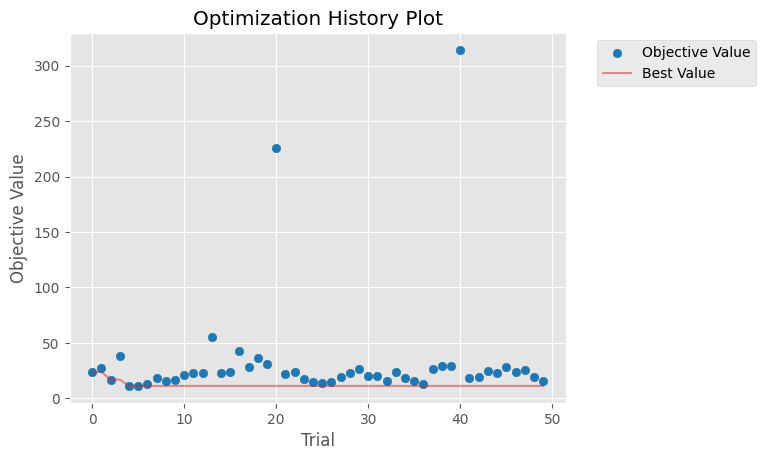

In [7]:
plot_optimization_history(study);

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_23164\2122237422.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study);


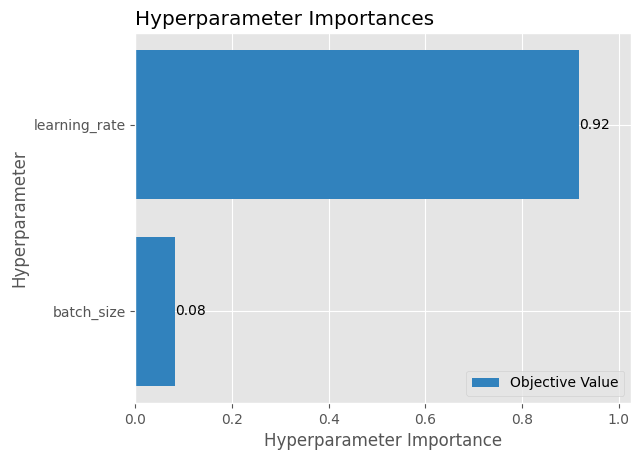

In [8]:
plot_param_importances(study);

# Cross-validation

## Data Pre-processing

In [9]:
# --- Parâmetros ---
LOOKBACK = 30
HORIZON = 12
BATCH_SIZE = 8
N_SPLITS = 7
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 15
LEARNING_RATE = study.best_params['learning_rate']

data_original = clean_data()
print(f"Tamanho dados originais: {len(data_original)}")

tscv = TimeSeriesSplit(n_splits=N_SPLITS, max_train_size=LOOKBACK+HORIZON*5, test_size=LOOKBACK+HORIZON, gap=-LOOKBACK)

fold_mae_orig = []
fold_mape_orig = []

Tamanho dados originais: 334


## Model Training & Results


===== Fold 1/7 =====
  Índices Treino: 0 a 69 (Tamanho: 70)
  Índices Teste: 40 a 81 (Tamanho: 42)
  Formato X_train: (29, 30), y_train: (29, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


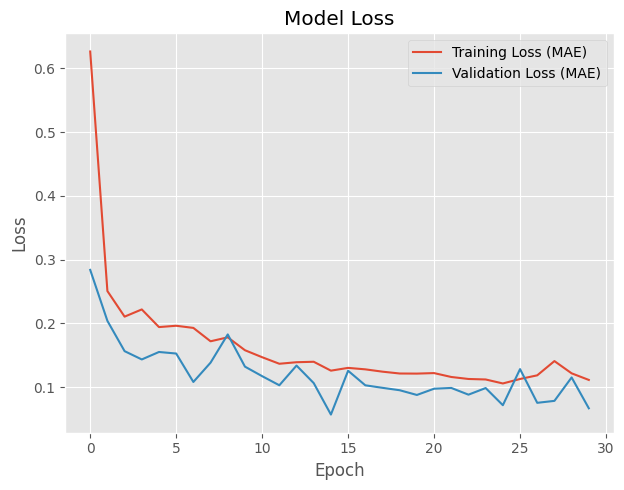

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 4.153 (3.64%)
Prediction for 3 Months/Year: MAE = 6.22 (5.169%)
Prediction for 1 Month/Year: MAE = 7.591 (6.538%)

===== Fold 2/7 =====
  Índices Treino: 22 a 111 (Tamanho: 90)
  Índices Teste: 82 a 123 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


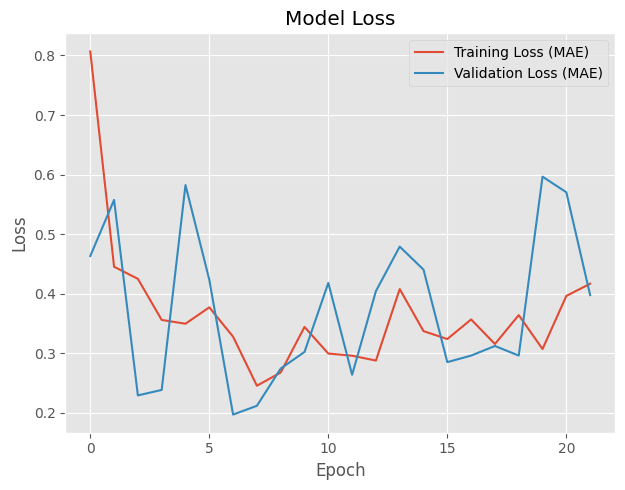

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 12.97 (10.63%)
Prediction for 3 Months/Year: MAE = 15.52 (12.9%)
Prediction for 1 Month/Year: MAE = 28.02 (23.33%)

===== Fold 3/7 =====
  Índices Treino: 64 a 153 (Tamanho: 90)
  Índices Teste: 124 a 165 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


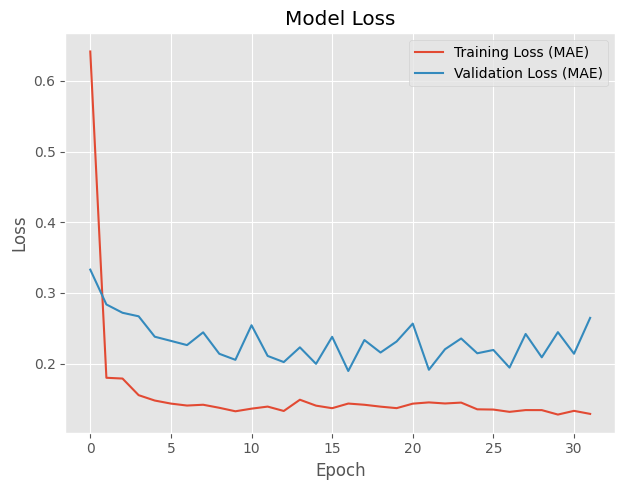

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 11.26 (8.306%)
Prediction for 3 Months/Year: MAE = 11.78 (8.541%)
Prediction for 1 Month/Year: MAE = 10.86 (7.938%)

===== Fold 4/7 =====
  Índices Treino: 106 a 195 (Tamanho: 90)
  Índices Teste: 166 a 207 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


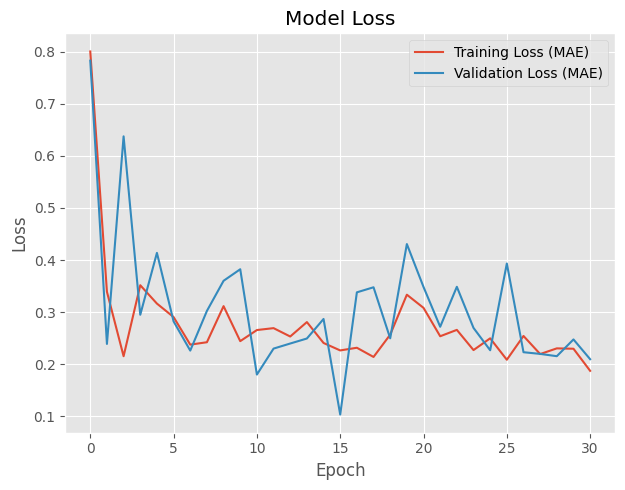

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 7.672 (4.893%)
Prediction for 3 Months/Year: MAE = 13.72 (8.178%)
Prediction for 1 Month/Year: MAE = 31.84 (18.77%)

===== Fold 5/7 =====
  Índices Treino: 148 a 237 (Tamanho: 90)
  Índices Teste: 208 a 249 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


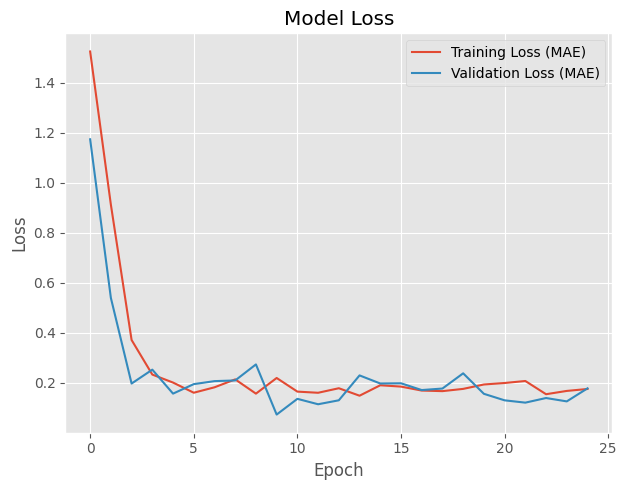

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 7.507 (4.367%)
Prediction for 3 Months/Year: MAE = 7.316 (4.664%)
Prediction for 1 Month/Year: MAE = 3.328 (2.183%)

===== Fold 6/7 =====
  Índices Treino: 190 a 279 (Tamanho: 90)
  Índices Teste: 250 a 291 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


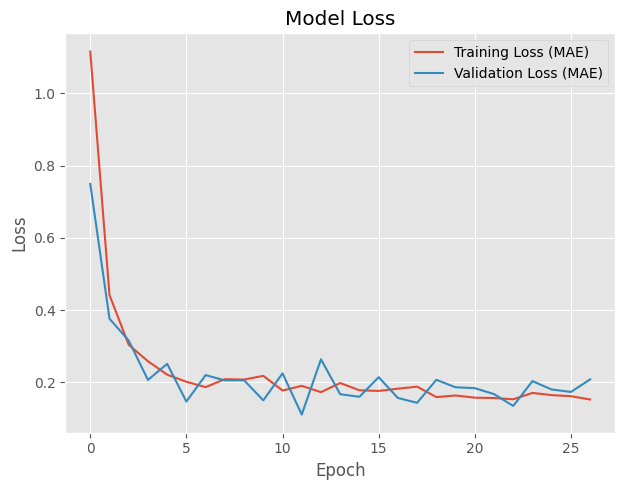

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 7.552 (4.074%)
Prediction for 3 Months/Year: MAE = 5.856 (3.227%)
Prediction for 1 Month/Year: MAE = 11.43 (6.297%)

===== Fold 7/7 =====
  Índices Treino: 232 a 321 (Tamanho: 90)
  Índices Teste: 292 a 333 (Tamanho: 42)
  Formato X_train: (49, 30), y_train: (49, 12)
  Formato X_val: (1, 30), y_val: (1, 12)


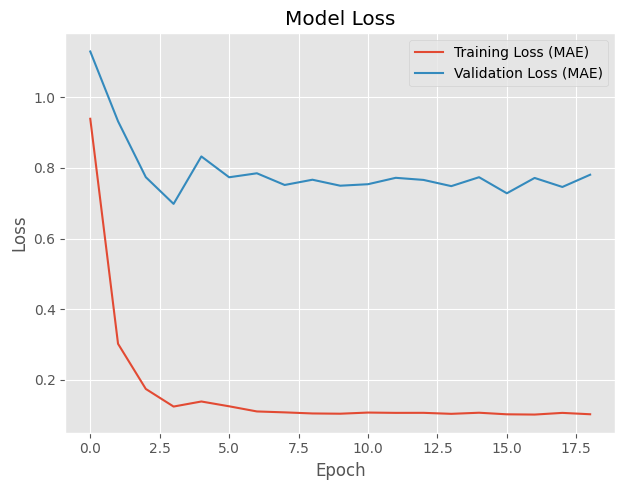

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step

--- Métricas de Erro (Escala Original) ---
Prediction for 12 Months/Year: MAE = 54.04 (22.52%)
Prediction for 3 Months/Year: MAE = 47.44 (20.04%)
Prediction for 1 Month/Year: MAE = 43.81 (18.69%)

===== Avaliação Média dos Testes nos Folds =====
MAE Médio Teste (escala original): 15.0218 +/- 16.1472
MAPE Médio Teste (escala original): 8.3467% +/- 6.2593%


In [10]:
for fold, (train_index, val_index) in enumerate(tscv.split(data_original.values)):
    print(f"\n===== Fold {fold + 1}/{N_SPLITS} =====")
    print(f"  Índices Treino: {train_index[0]} a {train_index[-1]} (Tamanho: {len(train_index)})")
    print(f"  Índices Teste: {val_index[0]} a {val_index[-1]} (Tamanho: {len(val_index)})")

    train_data =  data_original.iloc[train_index].values
    val_data =  data_original.iloc[val_index].values
    
    train_data_sc, val_data_sc, scaler = standardize_data_cv(train_data, val_data)
    
    X_train, y_train, X_val, y_val = create_sequences_cv(train_data_sc, val_data_sc, LOOKBACK, HORIZON)

    print(f"  Formato X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"  Formato X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    model = build_model(input_shape=(LOOKBACK, 1), horizon=HORIZON, learning_date=LEARNING_RATE)
    
    history = train(X_train, y_train, model,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                    early_stopping_patience=EARLY_STOPPING_PATIENCE)

    plot_history(history, fold)

    y_pred = model.predict(X_val) # Saída é (1, HORIZON)
    y_pred = scaler.inverse_transform(y_pred).flatten()

    y_true = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

    mae_12_months = mae(y_true, y_pred)
    mape_12_months = mape(y_true, y_pred)
    mae_3_months = mae(y_true[:3], y_pred[:3])
    mape_3_months = mape(y_true[:3], y_pred[:3])
    mae_1_month = mae([y_true[0]], [y_pred[0]])
    mape_1_month = mape([y_true[0]], [y_pred[0]])


    fold_mae_orig.append(mae_12_months)
    fold_mape_orig.append(mape_12_months)
    
    print(f"\n--- Métricas de Erro (Escala Original) ---")
    print(f"Prediction for 12 Months/Year: MAE = {mae_12_months:.4} ({mape_12_months*100:.4}%)")
    print(f"Prediction for 3 Months/Year: MAE = {mae_3_months:.4} ({mape_3_months*100:.4}%)")
    print(f"Prediction for 1 Month/Year: MAE = {mae_1_month:.4} ({mape_1_month*100:.4}%)")

# --- Avaliação Média da Validação Cruzada (Resultados de Teste) ---
print("\n===== Avaliação Média dos Testes nos Folds =====")
if fold_mae_orig:
    print(f"MAE Médio Teste (escala original): {np.mean(fold_mae_orig):.4f} +/- {np.std(fold_mae_orig):.4f}")
    print(f"MAPE Médio Teste (escala original): {np.mean(fold_mape_orig)*100:.4f}% +/- {np.std(fold_mape_orig)*100:.4f}%")
else:
    print("Nenhum fold completou o teste com sucesso.")

# DNN Model Forecast

## Data Pre-processing

In [11]:
# --- Parâmetros ---
LOOKBACK = 30
HORIZON = 12
BATCH_SIZE = 8
N_SPLITS = 5
EPOCHS = 50
EARLY_STOPPING_PATIENCE = 15

data_original = clean_data()

train_data =  data_original.iloc[:-2*HORIZON+1].values
val_data =  data_original.iloc[-LOOKBACK-2*HORIZON:-HORIZON].values
test_data =  data_original.iloc[-(LOOKBACK+HORIZON):].values

train_data_sc, val_data_sc, test_data_sc, scaler = standardize_data(train_data, val_data, test_data)

X_train, y_train, X_val, y_val, X_test, y_test = create_sequences(train_data_sc, val_data_sc, test_data_sc, LOOKBACK, HORIZON)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (270, 30, 1)
y_train shape: (270, 12)
X_val shape: (1, 30, 1)
y_val shape: (1, 12)
X_test shape: (1, 30, 1)
y_test shape: (1, 12)


## Model Training

In [ ]:
keras.utils.set_random_seed(49)
early_stopping_rounds = keras.callbacks.EarlyStopping(
        monitor='val_loss', # Monitora a perda na validação
        patience=20,
        restore_best_weights=True # Restaura os pesos da melhor época
    )

model = Sequential([
    Input(shape=(LOOKBACK, 1)),
    LSTM(units=64, activation='relu'),
    Dense(units=HORIZON)
])

    # Compiling the RNN
model.compile(loss='mae', optimizer=Adam(learning_rate=0.0720355032312233))

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, callbacks=[early_stopping_rounds])

y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred).flatten()
y_true = scaler.inverse_transform(y_test).flatten()

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 58578348.0000 - val_loss: 0.2784
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2079 - val_loss: 0.2376
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1786 - val_loss: 0.1986
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1551 - val_loss: 0.1458
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1490 - val_loss: 0.1735
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1333 - val_loss: 0.1605
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1292 - val_loss: 0.1433
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1302 - val_loss: 0.1292
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1333 - val_loss: 0.1320
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1373 - val_loss: 0.1348
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1331 - val_loss: 0.1301
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/st

## Results

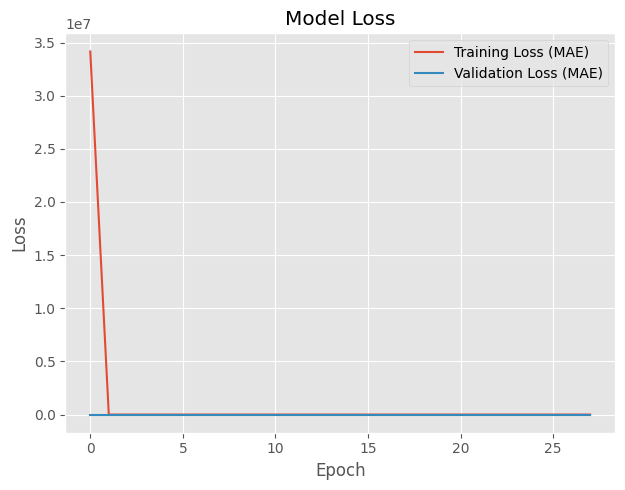

In [319]:
plot_history(history, 1)

In [320]:
mae_12_months = mae(y_true, y_pred)
mape_12_months = mape(y_true, y_pred)

mae_3_months = mae(y_true[0:3], y_pred[0:3])
mape_3_months = mape(y_true[0:3], y_pred[0:3])

mae_1_month = mae([y_true[0]], [y_pred[0]])
mape_1_month = mape([y_true[0]], [y_pred[0]])

print(f"Prediction for 12 Months/Year: MAE = {mae_12_months:.4} ({mape_12_months*100:.4}%)")
print(f"Prediction for 3 Months/Year: MAE = {mae_3_months:.4} ({mape_3_months*100:.4}%)")
print(f"Prediction for 1 Month/Year: MAE = {mae_1_month:.4} ({mape_1_month*100:.4}%)")

Prediction for 12 Months/Year: MAE = 15.17 (6.305%)
Prediction for 3 Months/Year: MAE = 6.007 (2.533%)
Prediction for 1 Month/Year: MAE = 1.202 (0.5127%)


In [321]:
forecast_out_sample = y_pred
forecast_in_sample = scaler.inverse_transform(model.predict(X_val)).flatten()

real_train = data_original.iloc[:-12].values.flatten()
real_test = data_original.iloc[-12:].values.flatten()

index = data_original.iloc[-12:].index
errors = real_test - forecast_out_sample

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_23164\1870870529.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-o" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(index, forecast_out_sample, 'k-o',color='skyblue', label='Predicted value')


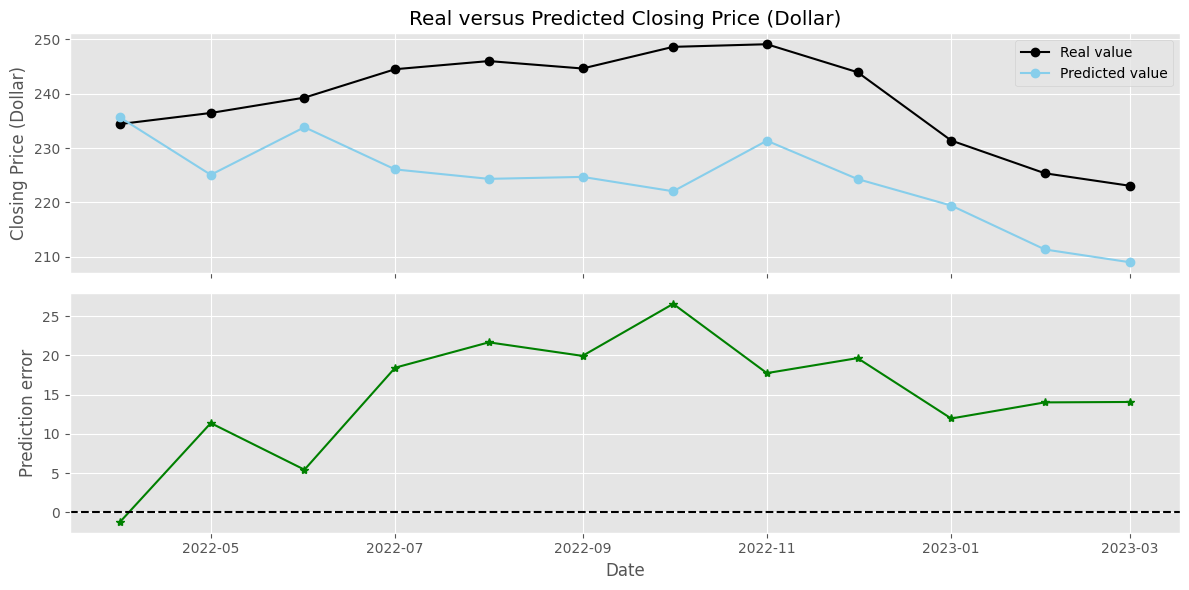

In [322]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# 1. Real vs Previsão
axs[0].plot(index, real_test, 'k-o', label='Real value')
axs[0].plot(index, forecast_out_sample, 'k-o',color='skyblue', label='Predicted value')
axs[0].set_title('Real versus Predicted Closing Price (Dollar)')
axs[0].set_ylabel('Closing Price (Dollar)')
axs[0].legend()
axs[0].grid(True)

# 2. Erros
axs[1].plot(index, errors, 'g-*')
axs[1].axhline(y=0, linestyle='--', color='k')
axs[1].set_ylabel('Prediction error')
axs[1].set_xlabel('Date')
axs[1].grid(True)

plt.tight_layout()
plt.show()

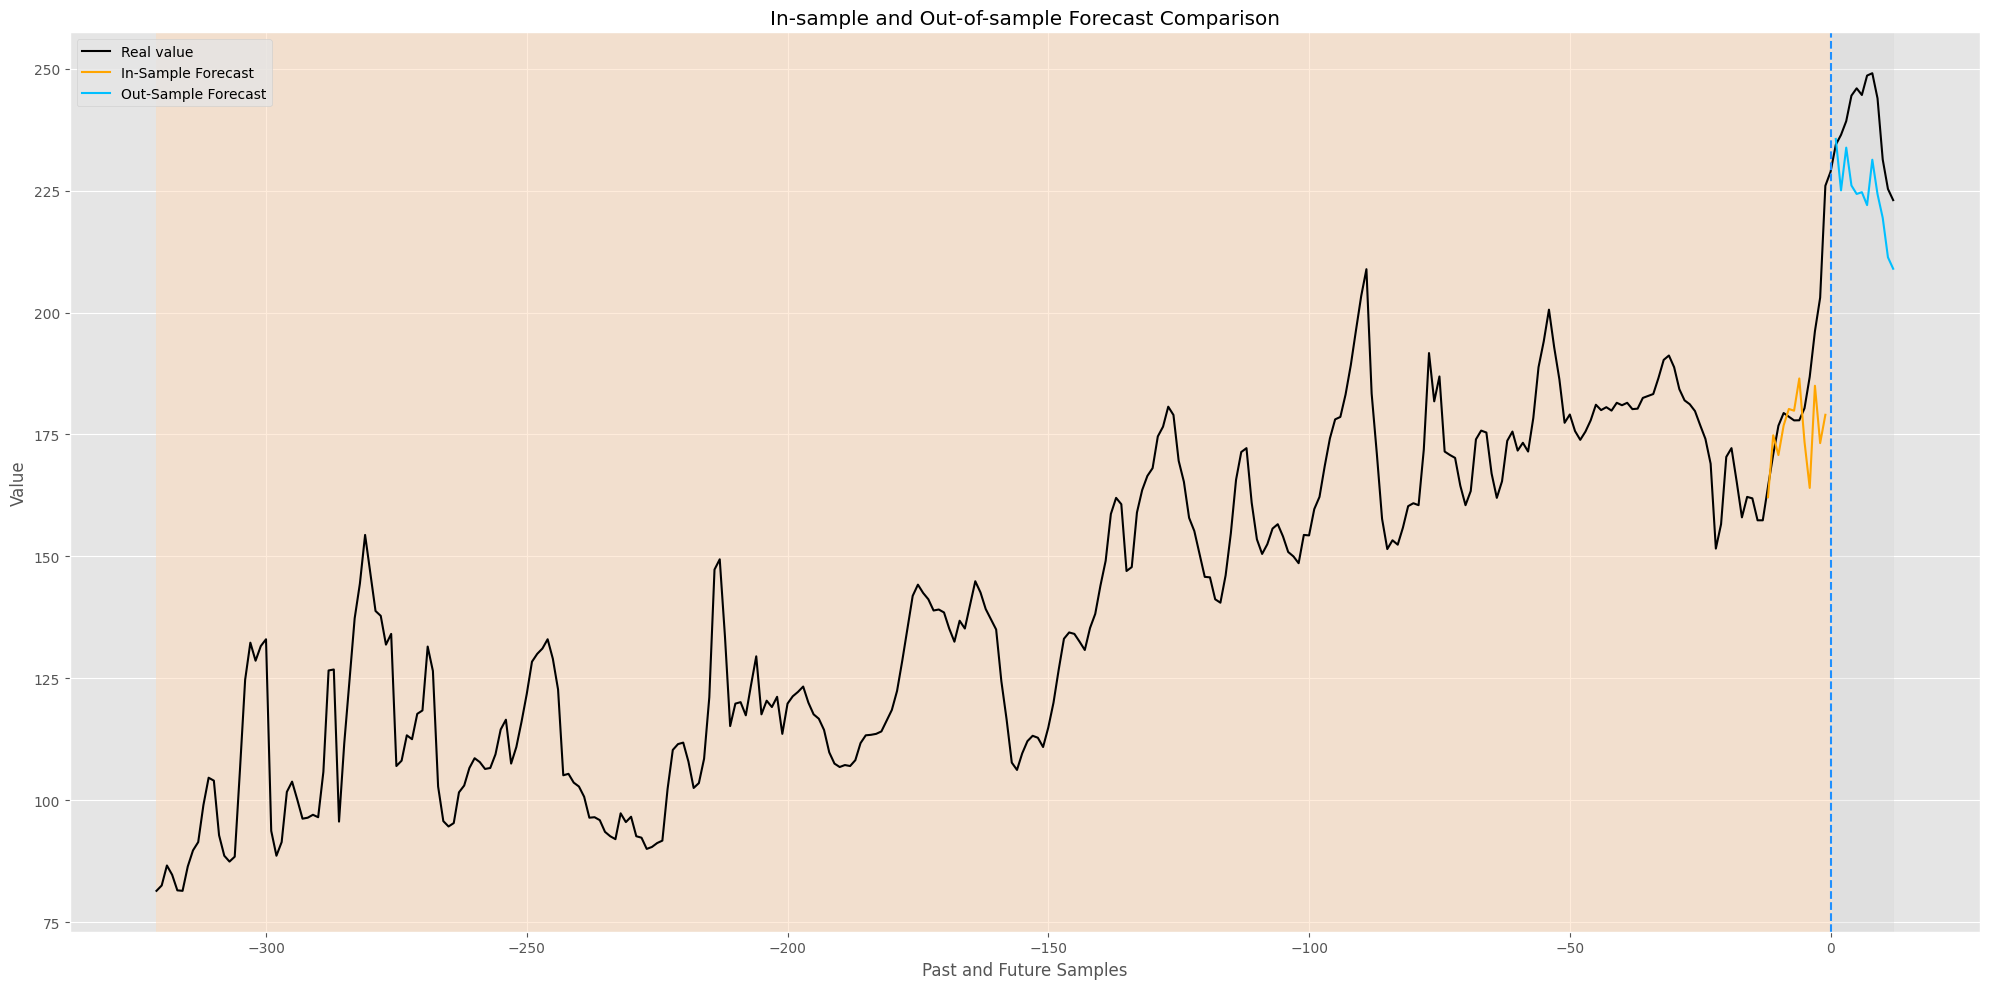

In [323]:
# Construção do eixo temporal artificial
x_real = np.arange(-(len(data_original)-12) + 1, 12 + 1)
x_in_sample = np.arange(-len(forecast_in_sample), 0)
x_out_sample = np.arange(1, len(forecast_out_sample) + 1)

# Gráfico
plt.figure(figsize=(20, 10))
plt.title('In-sample and Out-of-sample Forecast Comparison')

# Série real (linha preta)
plt.plot(x_real, np.concatenate([real_train, real_test]), 'k-', label='Real value')

# Previsões
plt.plot(x_in_sample, forecast_in_sample, color='orange', label='In-Sample Forecast')
plt.plot(x_out_sample, forecast_out_sample, color='deepskyblue', label='Out-Sample Forecast')

# Destaques visuais
plt.axvspan(x_real[0], 0, color='peachpuff', alpha=0.5)   # zona treino
plt.axvspan(0, x_real[-1], color='lightgray', alpha=0.3)  # zona teste
plt.axvline(0, color='dodgerblue', linestyle='--')       # divisão treino/teste

plt.xlabel('Past and Future Samples')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
